# Work flow with PyTorch

1. Get data ready (turn into tensors)
  * torch.vision.transforms
  * torch,utils.data.Dataset
  * torch.utils.data.DataLoader

2. Build or pick a pretrained model
  * pick a loss function and optimizer 
  * Build a training loop

  * torch.nn
  * torch.nn.Module
  * torchvisoin.models
  * torch.optim

3. Fit the model to the data and make a prediction

4. Evaluate the model
  * torchmatrics

5. improve through experimentation
  * torch.utils.tensorboard

6. Save and reload your trained model


In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'1.13.1+cu116'

## 1. Data (preparing and loading)

1. Get data into a numerical representaion

2. Build a model to learn patterns in that numerical representation

In [2]:
# create *known* parameters

weight = 0.7
bias = 0.3


#create 
start = 0 
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias

X[:10] , y[:10] 

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

### Spliting data into training and testing data

In [4]:
# Create a train/test dataset

train_split = int(0.8*len(X))

X_train, y_train = X[:train_split] , y[:train_split]
X_test, y_test = X[train_split:] , y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
from prompt_toolkit.widgets.base import Label
def plot_predections(train_data = X_train,
                     train_lables = y_train,
                     test_data = X_test,
                     test_lables = y_test,
                     predictions = None):
  """
  plots training data test data and compare predictions
  """

  plt.figure(figsize = (10,7))

  #plot training data in blue
  plt.scatter(train_data,train_lables,c='b',s=4, Label="Training data")

  #plot testing data in green
  plt.scatter(test_data,test_lables,c='g',s=4, Label="Testing data")

  #Are they predictions
  if predictions is not None:
    plt.scatter(test_data,predictions,c='r',s=4, Label="Predictions")
    
  # show it legend
  plt.legend(prop={"size":14})

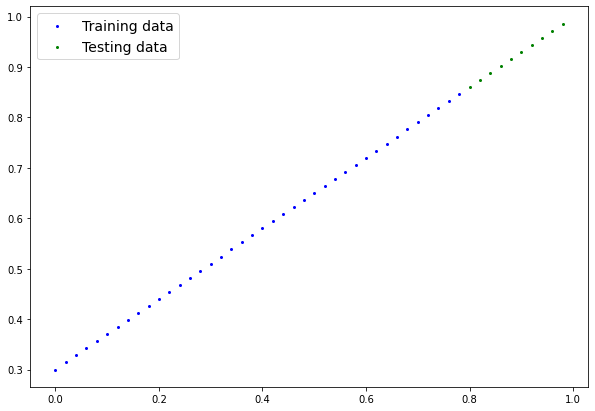

In [6]:
plot_predections()

## 2. Build a Model

* Start with random value (weight and bias)
* Look at training data and adjust the random values to better represent the ideal values (the weight and bias values we used to create)


How?
1. Gradiant descent
2. backpropagation

In [7]:
# assigned as Module attributes they are automatically added to the list of
# its parameters, and will appear e.g. in ~Module.parameters iterator.
# Assigning a Tensor doesn't have such effect. This is because one might
# want to cache some temporary state, like last hidden state of the RNN, in
# the model. If there was no such class as Parameter, these
# temporaries would get registered too.

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    #One might want to cache some temporary state like last hidden state of RNN in the  model
    self.weights = nn.Parameter(torch.randn(1, requires_grad = True, dtype = torch.float))
    self.bias = nn.Parameter(torch.rand(1, requires_grad = True, dtype = torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

  

### Pytorch model building essentials

* torch.nn contains all of the buildings for computational graph
* torch.Parameters - What parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module The base  class for all neural network Module. if you subclass it, you should overwrite  forward()
* torch.optim - This where the optimizers in pytorch live, They will help with gradient descent
* def forward()  All nn.module sublclasses require you to overwrite forward(), this methid defines what happens in the forward computation.

### Checking the contents of our PyTorch model

We can check our model parameters or what's inside our model using .parameters()

In [8]:
# Create a random seed

torch.manual_seed(42)


# Create an instance of the model (this is a subclass of nn.module)

model_0 = LinearRegressionModel()


# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.3904], requires_grad=True)]

In [9]:
# List named oarameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.3904]))])

In [10]:
weight, bias

(0.7, 0.3)

### Making predections using `torch.inference_mode()`

To check model's predict power let's see how well it predicts y_test based on X_test

When we pass data through our model, it's going to run it through the forward() method


In [11]:
# Maker predections with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.6598],
        [0.6665],
        [0.6733],
        [0.6800],
        [0.6867],
        [0.6935],
        [0.7002],
        [0.7069],
        [0.7137],
        [0.7204]])

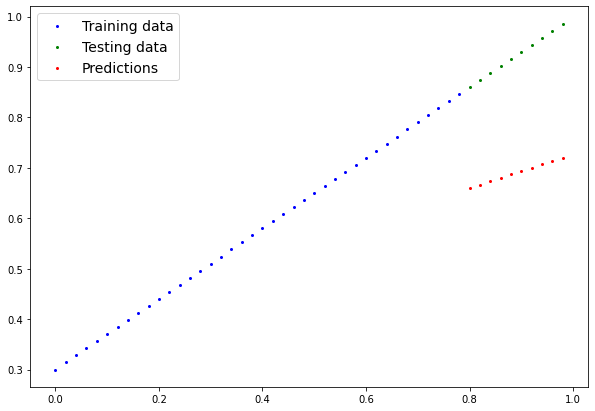

In [12]:
plot_predections(predictions=y_preds)

## 3. Train model

The whole idea of a training is for a model to move from some *unknown* parameters (these mayy be random) to some known paramters

Or in other words from a poor representations of the data to a better representaions of the data.

One way to measure how poor or how your models predictions are is to use a loss function.

loss funtion / cost function / criterion


Things we need to train:

* Loss Function
* Optimizer

in pytroch : training and testing loop

In [13]:
list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.3904], requires_grad=True)]

In [14]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.3904]))])

In [15]:
# setup a loss function
loss_fn = nn.L1Loss()

# setup an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.01)

### Building a training loop and a testing loop in pytorch.

What we need ?

1. loop through the data
2. forward pass
3. calculate the loss
4. loss backward
5. optimizer step

In [16]:
# An epoch is one loop through the data...

epochs = 200

epoch_count = []
loss_values = []
test_loss_values = []


# 0.Loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train()

  # Forward pass
  y_pred = model_0(X_train)

  # Loss function
  loss = loss_fn(y_pred, y_train)
  

  # Optimizer zero grad
  optimizer.zero_grad()

  # Perform backpropation on the loss with respect to the parameters of the model
  loss.backward()

  # step the optimizer (perform gradiant descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so.. we have to zero them above  backward()


  # turn off gradient tracking
  model_0.eval()

  with torch.inference_mode():
    test_pred = model_0(X_test)
    test_loss = loss_fn(test_pred, y_test)



  if(epoch % 10 == 0):
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} ] Loss: {loss} ] Test loss : {test_loss}")


Epoch: 0 ] Loss: 0.08169572055339813 ] Test loss : 0.22662055492401123
Epoch: 10 ] Loss: 0.06808149069547653 ] Test loss : 0.1807345449924469
Epoch: 20 ] Loss: 0.06258393079042435 ] Test loss : 0.15627031028270721
Epoch: 30 ] Loss: 0.05879194289445877 ] Test loss : 0.1418602615594864
Epoch: 40 ] Loss: 0.05530194193124771 ] Test loss : 0.13084018230438232
Epoch: 50 ] Loss: 0.051822252571582794 ] Test loss : 0.12050700187683105
Epoch: 60 ] Loss: 0.04838593676686287 ] Test loss : 0.11223447322845459
Epoch: 70 ] Loss: 0.044948760420084 ] Test loss : 0.10464880615472794
Epoch: 80 ] Loss: 0.04152031987905502 ] Test loss : 0.09637625515460968
Epoch: 90 ] Loss: 0.03808232396841049 ] Test loss : 0.08810374140739441
Epoch: 100 ] Loss: 0.034646838903427124 ] Test loss : 0.08051808178424835
Epoch: 110 ] Loss: 0.031217509880661964 ] Test loss : 0.0722455382347107
Epoch: 120 ] Loss: 0.027778705582022667 ] Test loss : 0.06397300213575363
Epoch: 130 ] Loss: 0.024344902485609055 ] Test loss : 0.0563873

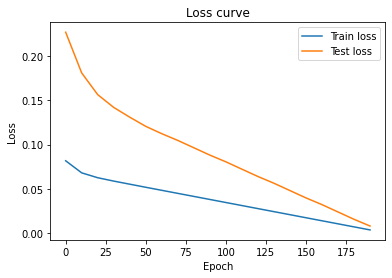

In [17]:
with torch.no_grad():

  plt.plot(epoch_count, loss_values, label="Train loss")
  plt.plot(epoch_count, test_loss_values, label="Test loss")
  plt.title("Loss curve")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.legend()

In [18]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

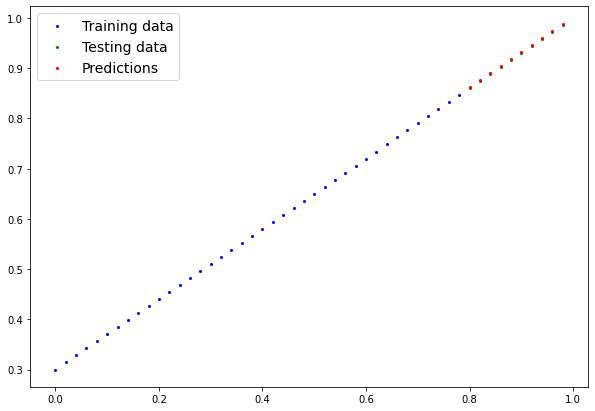

In [19]:
plot_predections(predictions=y_preds_new)

## Saving a model in PyTorch

There are three main methods you should acout for saving and loading in PyTorch

* torch.save()
* torch.load()
* torch.nn.Module.load_state_dict()

this use python pickle

In [20]:
# Saving our PyTorch model

from pathlib import Path

# Create a model directory

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)


MODEL_NAME = "pytorch_workflow_tutorial.pth"
MODEL_SAVE_PATH= MODEL_PATH/MODEL_NAME


#Save the models state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")

torch.save(obj = model_0.state_dict(), f = MODEL_SAVE_PATH)

Saving model to : models/pytorch_workflow_tutorial.pth


### Loading a Pytorch model

Since we saved a model's `state_dict()` rather the entore model, we'll create a new instance of our model class and load the saved `sate_model()` into that

In [22]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()


print(f"Before loading state dict : {loaded_model_0.state_dict()}")


# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

print(f"After loading state dict : {loaded_model_0.state_dict()}")



Before loading state dict : OrderedDict([('weights', tensor([1.1561])), ('bias', tensor([0.9346]))])
After loading state dict : OrderedDict([('weights', tensor([0.6962])), ('bias', tensor([0.3064]))])


In [23]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  y_preds_loaded = loaded_model_0(y_test)

model_0.eval()
with torch.inference_mode():
  y_preds = model_0(y_test)

y_preds_loaded == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting it all together

  Let's go back through the steps and see it all in one place

In [27]:
# import torch and matplotlib

import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'1.13.1+cu116'

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device : {device}")

Using device : cpu


In [29]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



1. Data 



## 6.2. Building a Pytorch Linear Model

In [35]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)


torch.manual_seed(42)

model_1 = LinearRegressionModelV2()

model_1, model_1.state_dict()


(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [36]:
# Set the model to use the target device

model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

## 6.3 Training

what we need

* Loss function
* Optimizer
* Training loop
* Testing loop

In [39]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [42]:
# training Loop
torch.manual_seed(42)

epochs = 200

# Put data in the same device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
  model_1.train()

  # 1. Forward Pass
  y_pred = model_1(X_train)


  # 2. Calculate the loss
  loss = loss_fn(y_pred,y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform back propogation
  loss.backward()


  # 5. update parameters
  optimizer.step()

  ### Testing

  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  if epoch%10 == 0:
     print(f"Epoch: {epoch} Loss: {loss} Test Loss : {test_loss}")

Epoch: 0 Loss: 0.5436569452285767 Test Loss : 0.5605052709579468
Epoch: 10 Loss: 0.42844706773757935 Test Loss : 0.42579537630081177
Epoch: 20 Loss: 0.31323719024658203 Test Loss : 0.2910855710506439
Epoch: 30 Loss: 0.1980273276567459 Test Loss : 0.1563757359981537
Epoch: 40 Loss: 0.0828174576163292 Test Loss : 0.021665919572114944
Epoch: 50 Loss: 0.023356426507234573 Test Loss : 0.048834484070539474
Epoch: 60 Loss: 0.019609849900007248 Test Loss : 0.04538799077272415
Epoch: 70 Loss: 0.01618141308426857 Test Loss : 0.03711546212434769
Epoch: 80 Loss: 0.012742981314659119 Test Loss : 0.028842901811003685
Epoch: 90 Loss: 0.0093079237267375 Test Loss : 0.02125726267695427
Epoch: 100 Loss: 0.005878164432942867 Test Loss : 0.012984687462449074
Epoch: 110 Loss: 0.002439356641843915 Test Loss : 0.004712158348411322
Epoch: 120 Loss: 0.010256484150886536 Test Loss : 0.0003308236482553184
Epoch: 130 Loss: 0.010256484150886536 Test Loss : 0.0003308236482553184
Epoch: 140 Loss: 0.01025648415088653

In [43]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6929]])),
             ('linear_layer.bias', tensor([0.2925]))])

## 6.4 Making and evaluating predictions

In [44]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

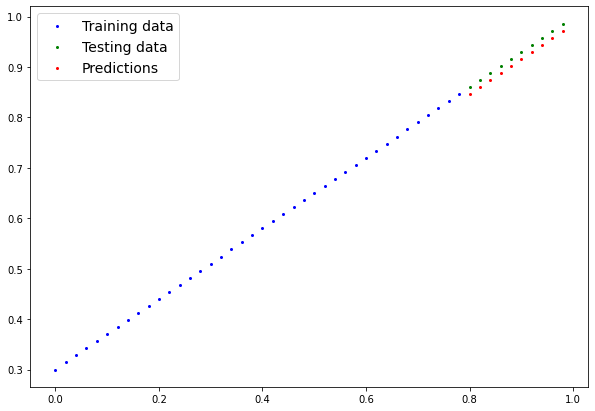

In [47]:
# Check out our redictions 
plot_predections(predictions=y_preds.cpu())

## 6.5 Saving and loading model

In [51]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "pytorch_workflow_tutorial_model_v1.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

#3.  Save the model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to : models/pytorch_workflow_tutorial_model_v1.pth


In [53]:
# Load a Pytorch model
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state _dict()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [54]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])